# LightGBM 

[Source]( https://microsoft.github.io/SynapseML/docs/features/lightgbm/LightGBM%20-%20Overview/)

[LightGBM](https://github.com/Microsoft/LightGBM) is an open-source,
distributed, high-performance gradient boosting (GBDT, GBRT, GBM, or
MART) framework. This framework specializes in creating high-quality and
GPU enabled decision tree algorithms for ranking, classification, and
many other machine learning tasks. LightGBM is part of Microsoft's
[DMTK](http://github.com/microsoft/dmtk) project.

### Advantages of LightGBM

-   **Composability**: LightGBM models can be incorporated into existing
    SparkML Pipelines, and used for batch, streaming, and serving
    workloads.
-   **Performance**: LightGBM on Spark is 10-30% faster than SparkML on
    the Higgs dataset, and achieves a 15% increase in AUC.  [Parallel
    experiments](https://github.com/Microsoft/LightGBM/blob/master/docs/Experiments.rst#parallel-experiment)
    have verified that LightGBM can achieve a linear speed-up by using
    multiple machines for training in specific settings.
-   **Functionality**: LightGBM offers a wide array of [tunable
    parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst),
    that one can use to customize their decision tree system. LightGBM on
    Spark also supports new types of problems such as quantile regression.
-   **Cross platform** LightGBM on Spark is available on Spark, PySpark, and SparklyR

### LightGBM Usage:

- LightGBMClassifier: used for building classification models. For example, to predict whether a company will bankrupt or not, we could build a binary classification model with LightGBMClassifier.
- LightGBMRegressor: used for building regression models. For example, to predict the house price, we could build a regression model with LightGBMRegressor.
- LightGBMRanker: used for building ranking models. For example, to predict website searching result relevance, we could build a ranking model with LightGBMRanker.

## Bankruptcy Prediction with LightGBM Classifier

<img src="https://mmlspark.blob.core.windows.net/graphics/Documentation/bankruptcy image.png" width="800" style="float: center;"/>

In this example, we use LightGBM to build a classification model in order to predict bankruptcy.

#### Read dataset

In [1]:
df = (
    spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load(
        "wasbs://publicwasb@mmlspark.blob.core.windows.net/company_bankruptcy_prediction_data.csv"
    )
)
# print dataset size
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(largepool, 1, 1, Finished, Available)

records read: 6819
Schema: 
root
 |-- Bankrupt?: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax ra

In [2]:
display(df)

StatementMeta(largepool, 0, 2, Finished, Available)

SynapseWidget(Synapse.DataFrame, 71ff84cb-ba39-4842-b6b4-794a60789303)

#### Split the dataset into train and test

In [3]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

StatementMeta(largepool, 0, 3, Finished, Available)

#### Add featurizer to convert features to vector

In [4]:
from pyspark.ml.feature import VectorAssembler

feature_cols = df.columns[1:]
featurizer = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = featurizer.transform(train)["Bankrupt?", "features"]
test_data = featurizer.transform(test)["Bankrupt?", "features"]

StatementMeta(largepool, 0, 4, Finished, Available)

#### Check if the data is unbalanced

In [5]:
display(train_data.groupBy("Bankrupt?").count())

StatementMeta(largepool, 0, 5, Finished, Available)

SynapseWidget(Synapse.DataFrame, 36770037-5bdf-4800-b736-ea7d7468337e)

#### Model Training

In [6]:
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(
    objective="binary", featuresCol="features", labelCol="Bankrupt?", isUnbalance=True
)

StatementMeta(largepool, 0, 6, Finished, Available)

In [7]:
model = model.fit(train_data)

StatementMeta(largepool, 0, 7, Finished, Available)

By calling "saveNativeModel", it allows you to extract the underlying lightGBM model for fast deployment after you train on Spark.

In [9]:
from synapse.ml.lightgbm import LightGBMClassificationModel

model.saveNativeModel("/models/lgbmclassifier.model")
model = LightGBMClassificationModel.loadNativeModelFromFile(
        "/models/lgbmclassifier.model"
    )

StatementMeta(largepool, 0, 9, Finished, Available)

#### Feature Importances Visualization

StatementMeta(largepool, 0, 12, Finished, Available)

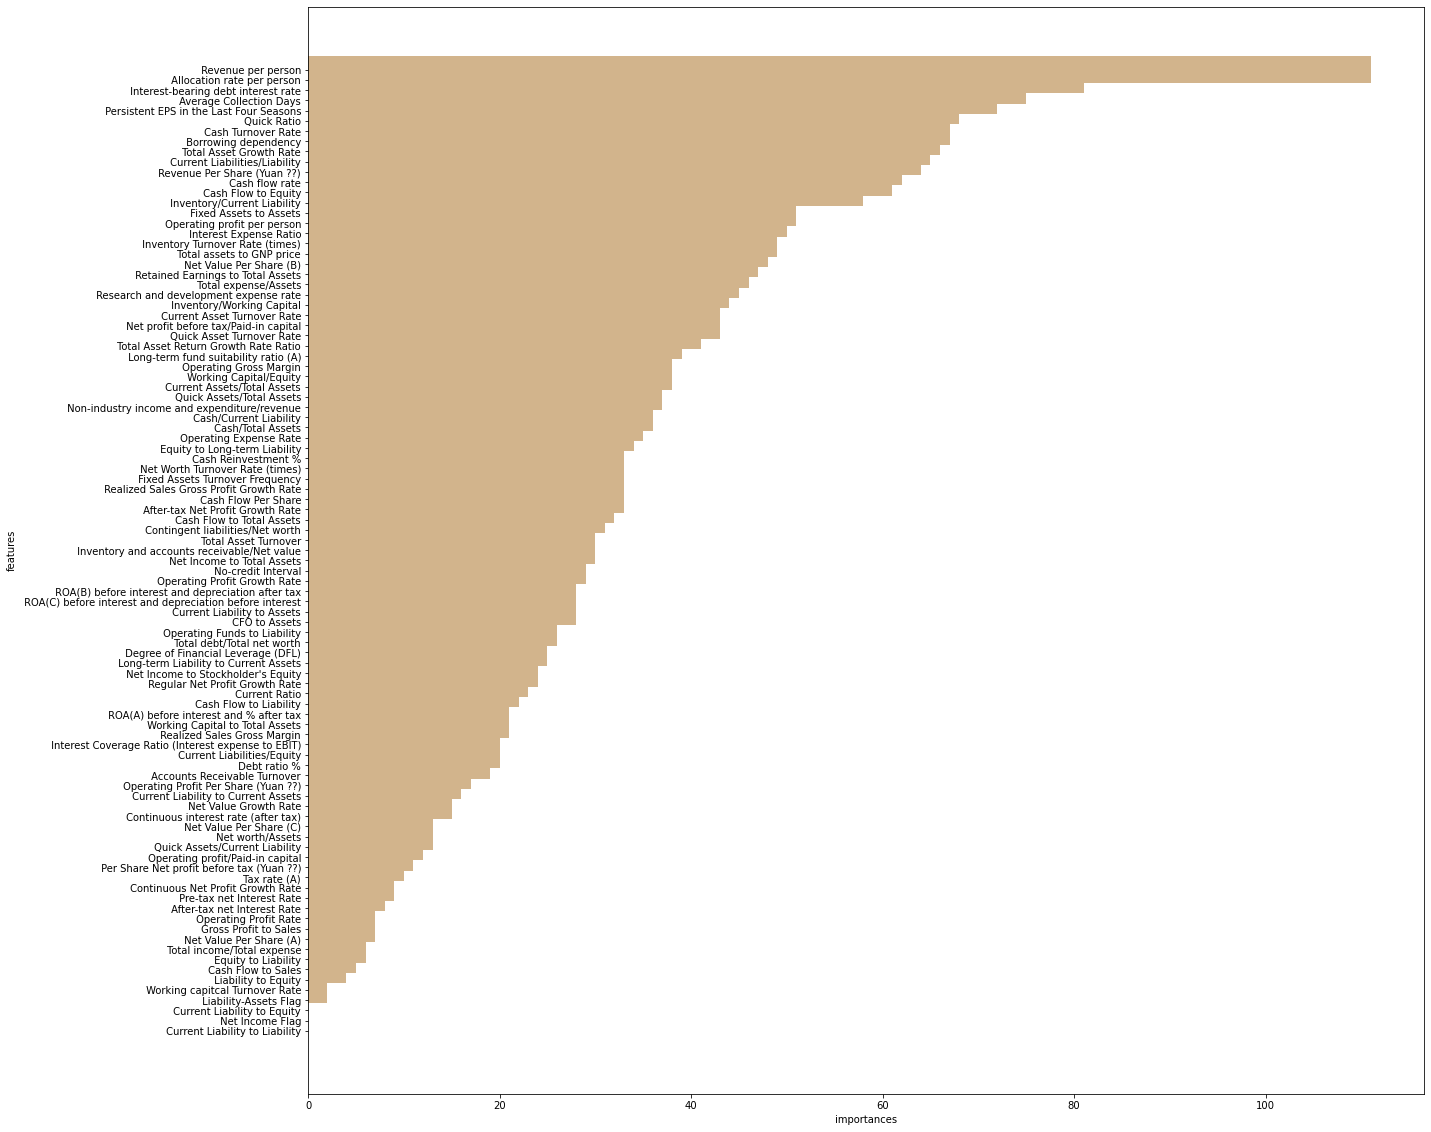

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model.getFeatureImportances()
fi = pd.Series(feature_importances, index=feature_cols)
fi = fi.sort_values(ascending=True)
f_index = fi.index
f_values = fi.values

# print feature importances
#print("f_index:", f_index)
#print("f_values:", f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x / len(fi) for x in x_index]
plt.rcParams["figure.figsize"] = (20, 20)
plt.barh(
    x_index, f_values, height=0.028, align="center", color="tan", tick_label=f_index
)
plt.xlabel("importances")
plt.ylabel("features")
plt.show()

#### Model Prediction

In [11]:
predictions = model.transform(test_data)
predictions.limit(10).toPandas()

StatementMeta(largepool, 0, 11, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


,Bankrupt?,features,rawPrediction,probability,prediction
0,0,"[0.204, 0.2638, 0.2598, 0.4483, 0.4483, 0.9959...","[2.090734224444767, -2.090734224444767]","[0.8899993271815234, 0.11000067281847664]",0.0
1,0,"[0.256, 0.287, 0.2821, 0.587, 0.587, 0.9989, 0...","[3.846053635586173, -3.846053635586173]","[0.9790829885669785, 0.020917011433021482]",0.0
2,0,"[0.269, 0.2646, 0.2836, 0.599, 0.599, 0.9734, ...","[3.989280378016158, -3.989280378016158]","[0.9818234709467417, 0.018176529053258297]",0.0
3,0,"[0.2852, 0.3701, 0.3698, 0.5964, 0.5964, 0.998...","[-5.761460563072316, 5.761460563072316]","[0.0031366430737871376, 0.9968633569262129]",1.0
4,0,"[0.3341, 0.394, 0.408, 0.6271, 0.6271, 0.976, ...","[8.793700110944231, -8.793700110944231]","[0.9998483373308248, 0.00015166266917520442]",0.0
5,0,"[0.3345, 0.3746, 0.371, 0.5983, 0.5983, 0.9988...","[8.027490614439916, -8.027490614439916]","[0.9996737403193753, 0.00032625968062466906]",0.0
6,0,"[0.3353, 0.3957, 0.391, 0.5667, 0.5667, 0.9982...","[4.171269536065305, -4.171269536065305]","[0.984801891796674, 0.015198108203326004]",0.0
7,0,"[0.3448, 0.3449, 0.3718, 0.5997, 0.5997, 0.998...","[5.617778138355859, -5.617778138355859]","[0.9963804452557602, 0.0036195547442398105]",0.0
8,0,"[0.3566, 0.3236, 0.3598, 0.5934, 0.5934, 0.998...","[5.334204454786345, -5.334204454786345]","[0.9951994107294074, 0.00480058927059257]",0.0
9,0,"[0.3618, 0.3587, 0.3888, 0.6199, 0.6199, 0.998...","[6.008068837960593, -6.008068837960593]","[0.9975471990241142, 0.002452800975885898]",0.0


In [13]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification",
    labelCol="Bankrupt?",
    scoredLabelsCol="prediction",
).transform(predictions)
display(metrics)

StatementMeta(largepool, 0, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, b4d0b607-8d82-46a3-be8c-ec66dd463ea0)

## Quantile Regression for Drug Discovery with LightGBMRegressor

<img src="https://mmlspark.blob.core.windows.net/graphics/Documentation/drug.png" width="800" style="float: center;"/>

In this example, we show how to use LightGBM to build a simple regression model.

#### Read dataset

In [14]:
triazines = spark.read.format("libsvm").load(
    "wasbs://publicwasb@mmlspark.blob.core.windows.net/triazines.scale.svmlight"
)

StatementMeta(largepool, 0, 14, Finished, Available)

In [15]:
# print some basic info
print("records read: " + str(triazines.count()))
print("Schema: ")
triazines.printSchema()
display(triazines.limit(10))

StatementMeta(largepool, 0, 15, Finished, Available)

records read: 105
Schema: 
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



SynapseWidget(Synapse.DataFrame, b13c6284-2630-46d3-8ad2-b011867d03bc)

#### Split dataset into train and test

In [16]:
train, test = triazines.randomSplit([0.85, 0.15], seed=1)

StatementMeta(largepool, 0, 16, Finished, Available)

#### Model Training

In [17]:
from synapse.ml.lightgbm import LightGBMRegressor

model = LightGBMRegressor(
    objective="quantile", alpha=0.2, learningRate=0.3, numLeaves=31
).fit(train)

StatementMeta(largepool, 0, 17, Finished, Available)

In [18]:
print(model.getFeatureImportances())

StatementMeta(largepool, 0, 18, Finished, Available)

[25.0, 2.0, 4.0, 0.0, 23.0, 13.0, 0.0, 11.0, 4.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 33.0, 18.0, 7.0, 23.0, 13.0, 0.0, 7.0, 0.0, 12.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0]


#### Model Prediction

In [19]:
scoredData = model.transform(test)
display(scoredData)

StatementMeta(largepool, 0, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 23466ff0-ae79-46fd-be0a-fce4a5a674df)

In [20]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="regression", labelCol="label", scoresCol="prediction"
).transform(scoredData)
display(metrics)

StatementMeta(largepool, 0, 20, Finished, Available)

SynapseWidget(Synapse.DataFrame, cd6a2774-472f-43af-8969-3ce4b559599a)

## LightGBM Ranker

#### Read dataset

In [21]:
df = spark.read.format("parquet").load(
    "wasbs://publicwasb@mmlspark.blob.core.windows.net/lightGBMRanker_train.parquet"
)
# print some basic info
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()
display(df.limit(10))

StatementMeta(largepool, 0, 21, Finished, Available)

records read: 3005
Schema: 
root
 |-- query: long (nullable = true)
 |-- labels: double (nullable = true)
 |-- features: vector (nullable = true)



SynapseWidget(Synapse.DataFrame, 74c174b0-e519-4e45-8395-d8e30dc0f153)

#### Model Training

In [22]:
from synapse.ml.lightgbm import LightGBMRanker

features_col = "features"
query_col = "query"
label_col = "labels"
lgbm_ranker = LightGBMRanker(
    labelCol=label_col,
    featuresCol=features_col,
    groupCol=query_col,
    predictionCol="preds",
    leafPredictionCol="leafPreds",
    featuresShapCol="importances",
    repartitionByGroupingColumn=True,
    numLeaves=32,
    numIterations=200,
    evalAt=[1, 3, 5],
    metric="ndcg",
)

StatementMeta(largepool, 0, 22, Finished, Available)

In [23]:
lgbm_ranker_model = lgbm_ranker.fit(df)

StatementMeta(largepool, 0, 23, Finished, Available)

#### Model Prediction

In [24]:
dt = spark.read.format("parquet").load(
    "wasbs://publicwasb@mmlspark.blob.core.windows.net/lightGBMRanker_test.parquet"
)
predictions = lgbm_ranker_model.transform(dt)
predictions.limit(10).toPandas()

StatementMeta(largepool, 0, 24, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,query,labels,features,preds,leafPreds,importances
0,0,2.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.87, 0.0, 0.75, 0....",0.953034,"[1.0, 18.0, 24.0, 25.0, 31.0, 6.0, 16.0, 7.0, ...","[-6.734115991884418e-05, 0.0, 0.0, 0.0, 0.0, 0..."
1,0,3.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.6, 0.8...",0.340661,"[1.0, 4.0, 2.0, 28.0, 26.0, 14.0, 3.0, 11.0, 1...","[-0.0003684299763296897, 0.0, 0.0, 0.0, 0.0, -..."
2,0,2.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.8, 0.0, 0.6, 0.0,...",0.253296,"[12.0, 18.0, 21.0, 24.0, 3.0, 8.0, 18.0, 9.0, ...","[0.0016453171754183386, 0.0, 0.0, 0.0, 0.0, -0..."
3,0,0.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.84, 0.81, 0.66, 0...",0.742632,"[26.0, 8.0, 18.0, 25.0, 3.0, 8.0, 18.0, 27.0, ...","[-0.0004979714536126963, 0.0, 0.0, 0.0, 0.0, -..."
4,0,2.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.91, 0.81, 0.83, 0...",0.347543,"[25.0, 18.0, 24.0, 27.0, 3.0, 8.0, 17.0, 11.0,...","[-0.0012758411427339807, 0.0, 0.0, 0.0, 0.0, 0..."
5,0,1.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-1.065882,"[20.0, 3.0, 27.0, 19.0, 25.0, 8.0, 18.0, 12.0,...","[0.0004916101344502373, 0.0, 0.0, 0.0, 0.0, -0..."
6,0,2.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.86, 0.0, 0.7, 0.8...",-1.318996,"[1.0, 2.0, 1.0, 28.0, 2.0, 3.0, 2.0, 2.0, 11.0...","[0.0015899674103454432, 0.0, 0.0, 0.0, 0.0, 0...."
7,0,0.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.86, 0.81, 0.68, 0...",0.617225,"[27.0, 18.0, 24.0, 22.0, 27.0, 6.0, 17.0, 11.0...","[-0.00042540629400014446, 0.0, 0.0, 0.0, 0.0, ..."
8,0,2.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.86, 0.0, 0.77, 0....",-0.395975,"[1.0, 2.0, 14.0, 9.0, 2.0, 3.0, 2.0, 2.0, 11.0...","[0.0015899674103454432, 0.0, 0.0, 0.0, 0.0, 0...."
9,0,1.0,"(0.74, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-4.344095,"[15.0, 7.0, 4.0, 3.0, 3.0, 3.0, 3.0, 6.0, 23.0...","[-0.0006663355977336439, 0.0, 0.0, 0.0, 0.0, -..."
